**ENSEMBLE LEARNING**

Exercise 1: Souped-up Regression Trees


Introduction:
The default implementation of Decision Trees for Regression in the scikit-learn library does not support using a regression method in the leaves of the tree. In this exercise you implement solutions to this problem, and you will evaluate their effect on predictive performance.

In [299]:
import numpy as np  # linear algebra
import pandas as pd  # data processing
from sklearn.tree import DecisionTreeRegressor  # model
from matplotlib import pyplot as plt  # visualization
from sklearn.tree import plot_tree  # visualize tree

In [300]:
def WordDescreptionToNumbers(word_list):
  '''
      Ex	Excellent = 5
      Gd	Good = 4
      TA	Average/Typical = 3
      Fa	Fair = 2
      Po	Poor = 1
  '''
  word_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
  return [word_dict[word] for word in word_list]

def HeatingWordDescreptionToNumbers(word_list):
  '''
        Floor	Floor Furnace
        GasA	Gas forced warm air furnace
        GasW	Gas hot water or steam heat
        Grav	Gravity furnace	
        OthW	Hot water or steam heat other than gas
        Wall	Wall furnace
  '''
  heating_word_dict = {'Floor': 6 , 'GasA' : 5 , 'GasW' : 4 , 'Grav' : 3 ,'OthW': 2 , 'Wall' : 1}
  return [heating_word_dict[word] for word in word_list]

"house_prices" Dataset (https://www.kaggle.com/code/chazzer/ml-grandmaster-decision-tree-regressor/data)

In [301]:
df = pd.read_csv('/content/sample_data/house_prices_train.csv')

In [302]:
def preprocess(df):
    cols_to_drop = [col for col in df.columns if col not in ['Pool','PoolArea','OverallQual','LotArea','NewCostruction','OverallCond','ExterQual','ExterCond','Heating','SalePrice']]
    cols_to_drop.append('PoolArea')
    df['Pool'] = (df['PoolArea'] > 0).astype('int64')
    df['NewConstruction'] = (df['SaleType'] == 'New').astype('int64')
    #ExterQual: Evaluates the quality of the material on the exterior
    df ['ExterQual'] = WordDescreptionToNumbers(df['ExterQual'])
    #ExterCond: Evaluates the present condition of the material on the exterior
    df['ExterCond'] = WordDescreptionToNumbers(df['ExterCond'])
    df['Heating'] = HeatingWordDescreptionToNumbers(df['Heating'])
    df['SalePrice'] = df['SalePrice'] // 1000
    # df['SalePrice'] = df['SalePrice']
    df = df.drop(columns=cols_to_drop)
    # df = df[['NewConstruction', 'Pool', 'LotArea','OverallQual', 'SalePrice']]
    
    return df

In [303]:
# df = df.loc[df.index.isin([197, 810, 11, 18, 1449])]
df = df.loc[df.index.isin([i for i in range(1000)])]
df = preprocess(df)
# df


testtttttt 
dont forget to delete it or wirte something 

In [304]:
# defining our tree object with the hyper parameters discussed above
model = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    min_samples_split=4,
    max_depth = 5 
)

# CART algorithm that builds the tree based on our data
model.fit(
    X=df.drop(columns=['SalePrice']), 
    y=df['SalePrice']
)

DecisionTreeRegressor(max_depth=5, min_samples_split=4)

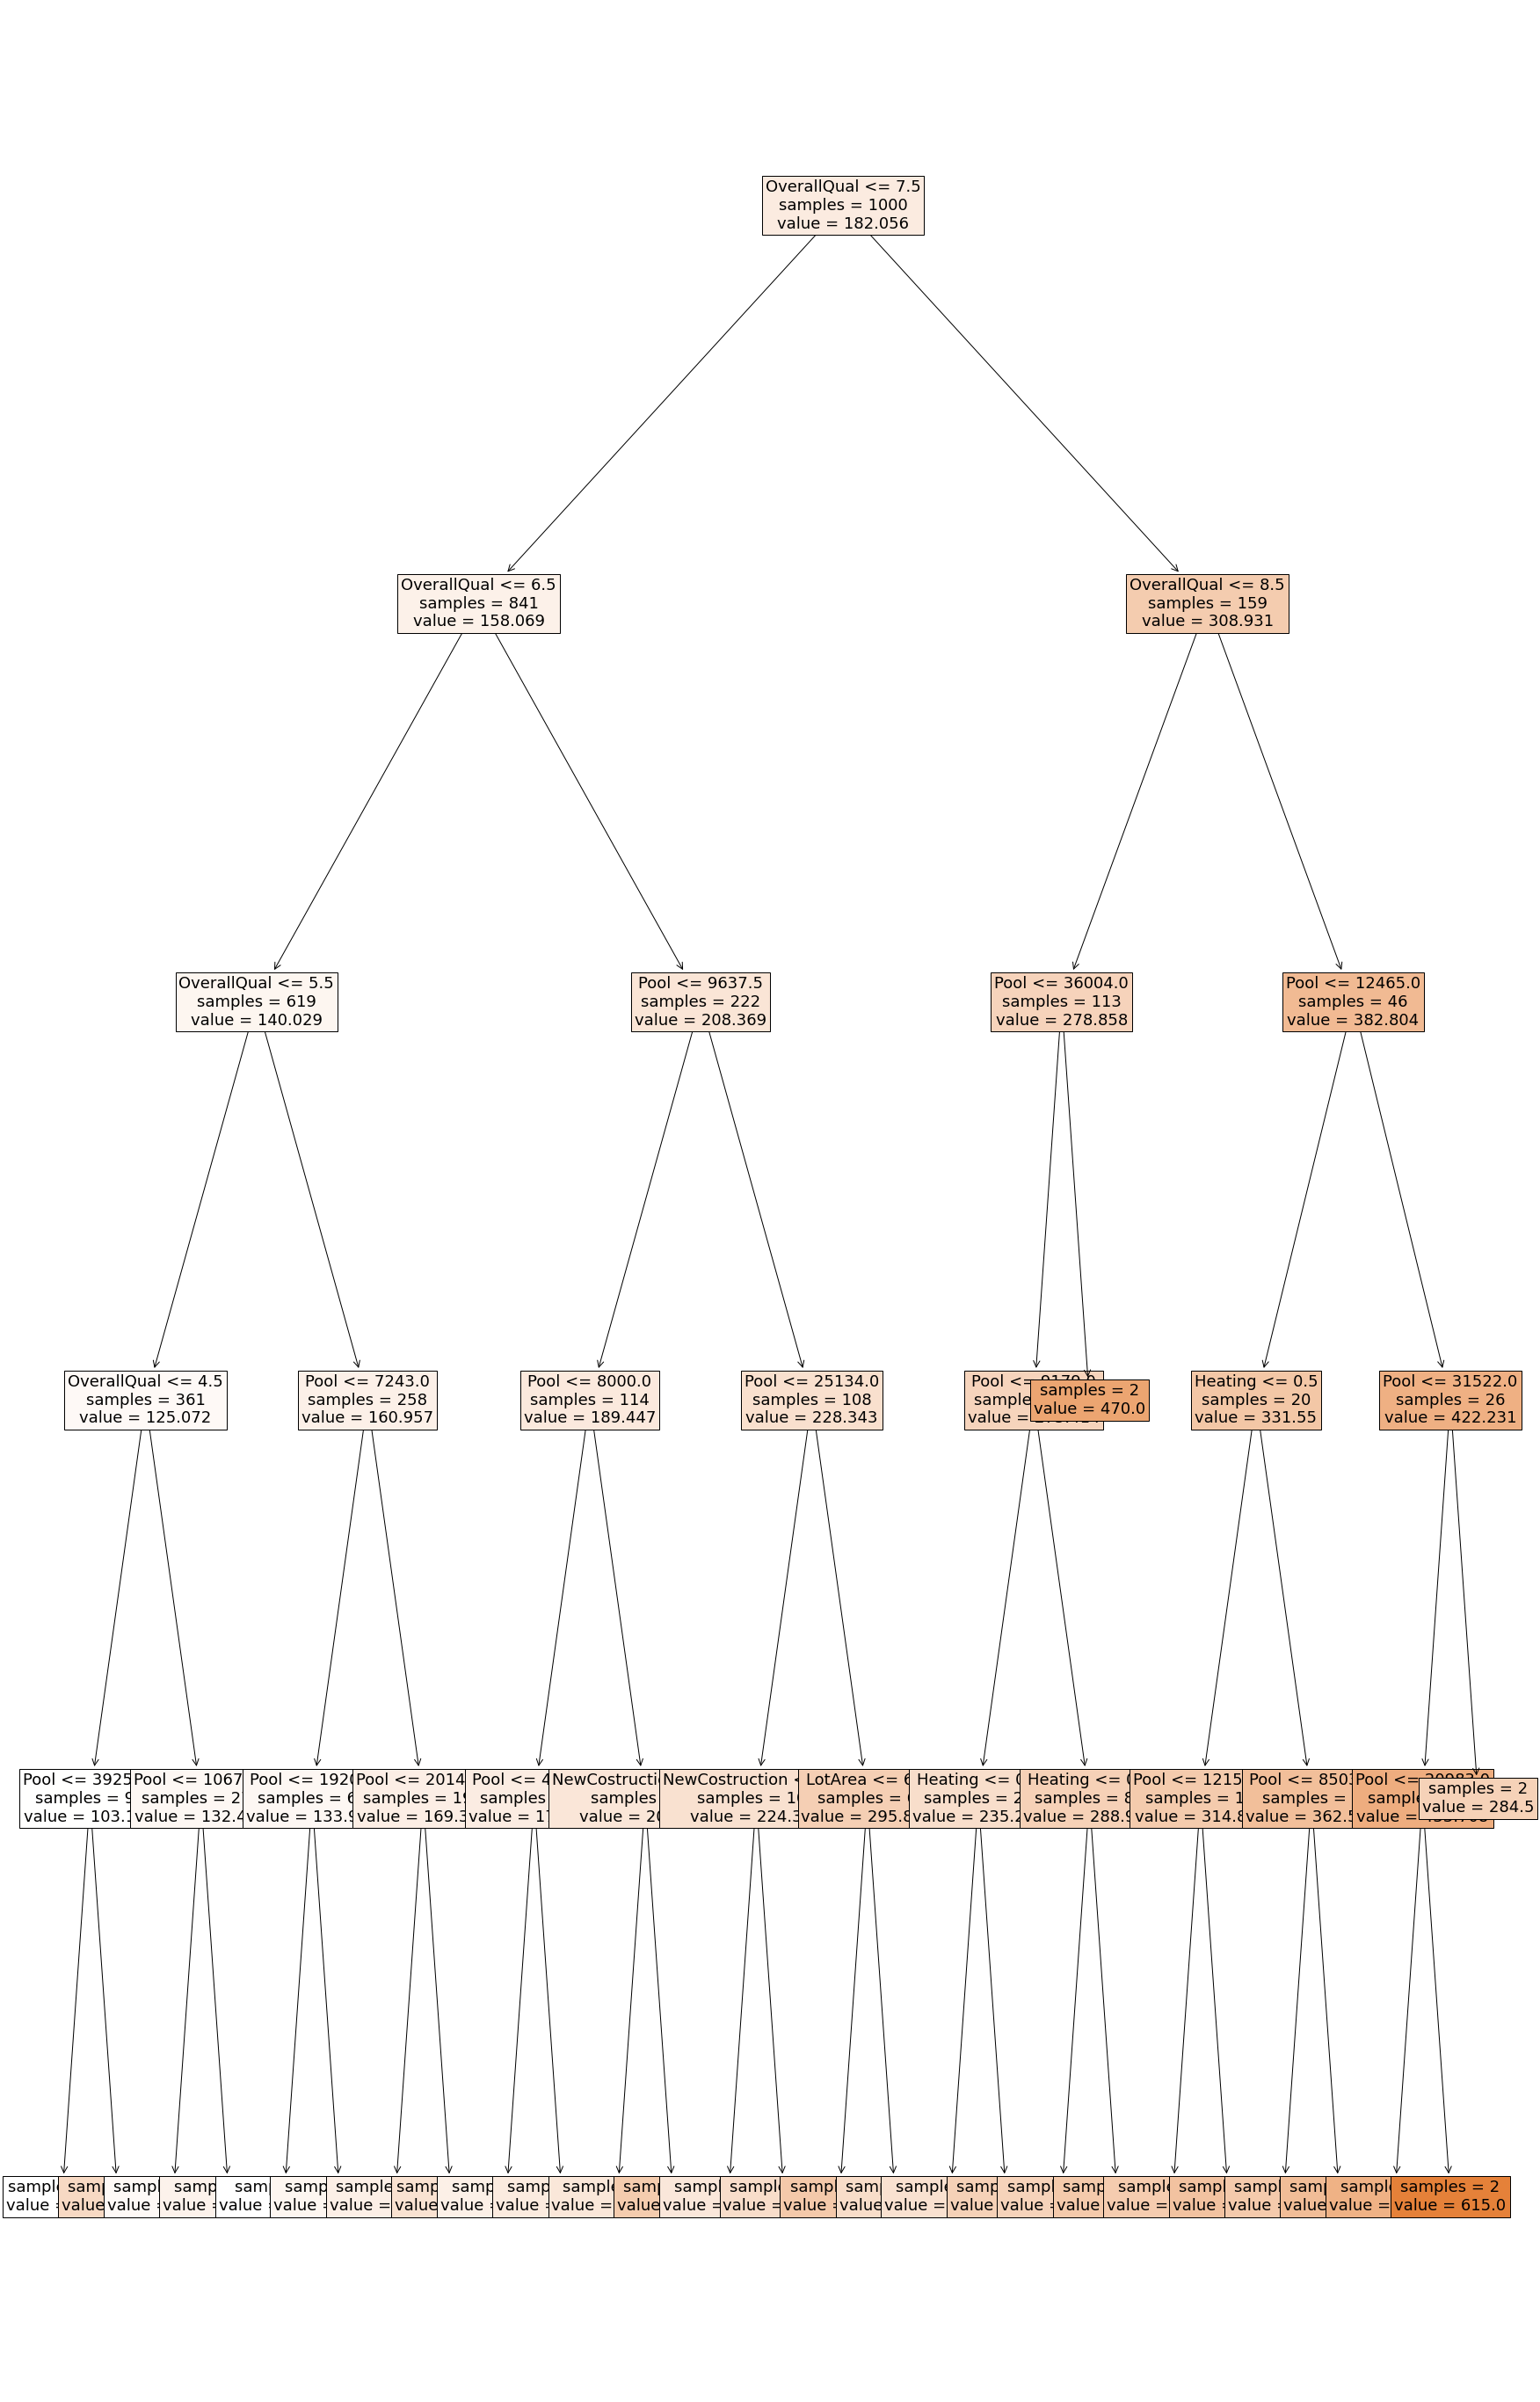

In [305]:
plt.figure(figsize=(30, 50))
plot_tree(
    model,
    feature_names=['Pool','OverallQual','LotArea','NewCostruction','OverallCond','ExterQual','ExterCond','Heating'],
    impurity=False,
    filled=True,
    fontsize=18
)
plt.show()

In [306]:
# 'Pool','PoolArea','OverallQual','LotArea','NewCostruction','OverallCond','ExterQual','ExterCond','Heating','SalePrice']
# 
inputs = pd.DataFrame([{"NewConstruction": 0, "Pool": 0,"OverallQual":3,"OverallCond":3,"ExterQual":3,"ExterCond":3,"Heating":4, "LotArea": 10206}])
prediction = model.predict(inputs)
print(f"Predicted SalePrice: {prediction}")

#sample number 1001
# 82000

Predicted SalePrice: [101.5]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
